<a href="https://colab.research.google.com/github/VishwanthReddy99/DeepLearning-Projects/blob/main/FaceMaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('FaceMaskDetection')
jovian.set_colab_id('asdadaddadadad')

     |████████████████████████████████| 71kB 3.7MB/s 


In [2]:
!pip install jovian --upgrade --quiet

In [3]:
!pip install opendatasets


In [4]:
import opendatasets as od

In [5]:
url="https://www.kaggle.com/omkargurav/face-mask-dataset"


In [6]:
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: v170399
Your Kaggle Key: ··········


  0%|          | 0.00/163M [00:00<?, ?B/s]

100%|██████████| 163M/163M [00:07<00:00, 22.9MB/s]


In [7]:
#Importing the dataset
import os
import torchvision
from torchvision.datasets import ImageFolder
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [9]:
data_dir="/content/face-mask-dataset/data"

In [10]:
os.listdir(data_dir)

['with_mask', 'without_mask']

In [11]:
dataset=ImageFolder(data_dir)


In [12]:
len(dataset)

7553

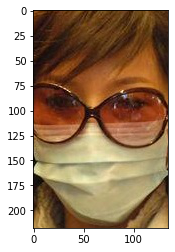

In [13]:
#Showing image
import matplotlib.pyplot as plt
img,label=dataset[1]
plt.imshow(img)

In [56]:
import torchvision.transforms as tt
dataset=ImageFolder(data_dir,tt.Compose([tt.Resize(64),tt.RandomCrop(64),
    tt.RandomHorizontalFlip(),
    
    tt.ToTensor(),

    ]

))


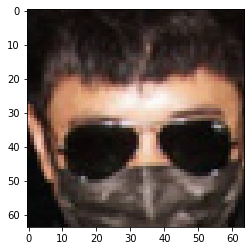

In [18]:


img,label=dataset[250]
plt.imshow(img.permute((1,2,0)))

In [19]:

val_pct=0.2
val_size=int(val_pct*len(dataset))
train_size=len(dataset)-val_size
train_size,val_size

(6043, 1510)

In [20]:

from torch.utils.data import random_split

train_ds,valid_ds=random_split(dataset,[train_size,val_size])

In [21]:
from torch.utils.data import DataLoader

batch_size=15

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=3, pin_memory=True)


tensor([1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0])


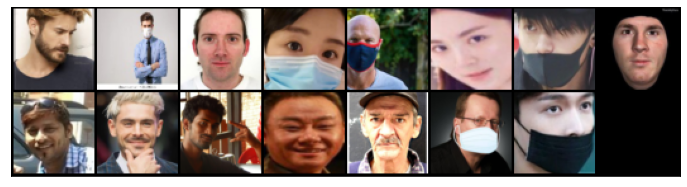

In [22]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        print(labels)
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

show_batch(train_dl)

In [23]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [24]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [25]:
device = get_default_device()
device

device(type='cuda')

In [26]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
print(len(train_dl))
print(len(valid_dl))

403
101


In [31]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions

        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [32]:
torch.cuda.empty_cache()


In [33]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.conv5=conv_block(512,1024)
        self.res3 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))
        self.conv6=conv_block(1024,2048)
        self.res4 = nn.Sequential(conv_block(2048, 2048), conv_block(2048, 2048))


        


        self.flat=nn.Flatten()
        self.drop=nn.Dropout(0.2)
        self.classifier = nn.Sequential(nn.MaxPool2d(2), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)

        out = self.res1(out) + out

        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out=self.conv5(out)
        out=self.res3(out)+out
        out=self.conv6(out)
        out=self.res4(out)+out

        


        out=self.flat(out)
        out=self.drop(out)
        return out

In [34]:
model = to_device(ResNet9(3, 2), device)
model


ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [36]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [37]:
history = [evaluate(model, valid_dl)]
history


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[{'val_acc': 0.0, 'val_loss': 11.774664878845215}]

In [38]:
epochs = 20
max_lr = 0.01
grad_clip = 0.3
weight_decay = 1e-4
opt_func = torch.optim.Adam
history=[]

In [39]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [0], last_lr: 0.00104, train_loss: 2.9357, val_loss: 1.2610, val_acc: 0.8957


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [1], last_lr: 0.00280, train_loss: 2.7505, val_loss: 1.4452, val_acc: 0.8429


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [2], last_lr: 0.00520, train_loss: 2.7912, val_loss: 0.9193, val_acc: 0.9188


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [3], last_lr: 0.00760, train_loss: 2.7552, val_loss: 0.8366, val_acc: 0.9152


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [4], last_lr: 0.00936, train_loss: 2.6630, val_loss: 1.4885, val_acc: 0.6013


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [5], last_lr: 0.01000, train_loss: 2.7129, val_loss: 0.8322, val_acc: 0.8528


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [6], last_lr: 0.00987, train_loss: 2.6334, val_loss: 1.4572, val_acc: 0.8492


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [7], last_lr: 0.00950, train_loss: 2.5840, val_loss: 0.6097, val_acc: 0.9053


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [8], last_lr: 0.00891, train_loss: 2.5947, val_loss: 1.2458, val_acc: 0.7300


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [9], last_lr: 0.00812, train_loss: 2.5976, val_loss: 1.2869, val_acc: 0.7271


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [10], last_lr: 0.00717, train_loss: 2.6630, val_loss: 0.6690, val_acc: 0.9403


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [11], last_lr: 0.00611, train_loss: 2.5517, val_loss: 0.6411, val_acc: 0.9281


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [12], last_lr: 0.00500, train_loss: 2.5034, val_loss: 0.6334, val_acc: 0.9422


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [13], last_lr: 0.00389, train_loss: 2.5920, val_loss: 0.4487, val_acc: 0.9432


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [14], last_lr: 0.00283, train_loss: 2.5688, val_loss: 0.4251, val_acc: 0.9644


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [15], last_lr: 0.00188, train_loss: 2.5482, val_loss: 0.3375, val_acc: 0.9677


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [16], last_lr: 0.00109, train_loss: 2.4613, val_loss: 0.2933, val_acc: 0.9650


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [17], last_lr: 0.00050, train_loss: 2.4730, val_loss: 0.2818, val_acc: 0.9736


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [18], last_lr: 0.00013, train_loss: 2.4632, val_loss: 0.2649, val_acc: 0.9729


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [19], last_lr: 0.00000, train_loss: 2.4695, val_loss: 0.2867, val_acc: 0.9756
CPU times: user 25min 9s, sys: 21min 40s, total: 46min 50s
Wall time: 47min 38s


In [40]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

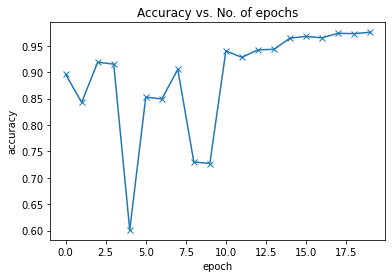

In [41]:
plot_accuracies(history)

In [44]:
test_data_link="https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset"

In [45]:
od.download(test_data_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: v170399
Your Kaggle Key: ··········


  0%|          | 0.00/330M [00:00<?, ?B/s]

100%|██████████| 330M/330M [00:06<00:00, 50.0MB/s]


In [53]:
td='/content/face-mask-12k-images-dataset/Face Mask Dataset/Test'

In [55]:
os.listdir(td)

['WithoutMask', 'WithMask']

In [54]:
test_data=ImageFolder(td)

In [59]:
import torchvision.transforms as tt
test_data=ImageFolder(td,tt.Compose([tt.Resize(64),tt.RandomCrop(64),
    tt.RandomHorizontalFlip(),
    
    tt.ToTensor(),

    ]

))


In [60]:
test_loader = DeviceDataLoader(DataLoader(test_data, batch_size=15), device)


In [61]:
result = evaluate(model,test_loader)
result

{'val_acc': 0.9422885179519653, 'val_loss': 0.4063688814640045}

In [62]:
torch.save(model.state_dict(), 'FaceMaskDetection.pth')


In [63]:
jovian.log_hyperparams(arch='CatsvsDogs', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [64]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   )

[jovian] Metrics logged.
